In [ ]:
import sys
from pathlib import Path
import pandas as pd
import warnings
import joblib

project_path = Path.cwd().parent
sys.path.append(project_path.as_posix())
from loguru import logger

from scripts.plot_utils import plot_regression, plot_residuals
from scripts.evaluate import model_eval
import matplotlib.pyplot as pp
import matplotlib.style as style

In [30]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [47]:
style.use('bmh')

In [40]:
dX_test = pd.read_parquet(project_path/'models/dX_test.pqt')
dY_test = pd.read_parquet(project_path/'models/dY_test.pqt')

In [41]:
dY_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252322 entries, 1229093 to 1217922
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   dia        252322 non-null  float64
 1   chl        252322 non-null  float64
 2   cya        252322 non-null  float64
 3   coc        252322 non-null  float64
 4   din        252322 non-null  float64
 5   pha        252322 non-null  float64
 6   tot_cphyl  252322 non-null  float64
dtypes: float64(7)
memory usage: 15.4 MB


In [42]:
# Reloading the optimzied and trained model
optimized_model = joblib.load(project_path / "models/optimized_trained_model.pkl")
logger.info("Model loaded successfully.")

2025-03-20 13:13:19.515 | INFO     | __main__:<module>:3 - Model loaded successfully.


In [43]:
dY_pred = optimized_model.predict(dX_test)
dY_pred = pd.DataFrame(dY_pred, columns=dY_test.columns)

In [44]:
dY_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252322 entries, 0 to 252321
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   dia        252322 non-null  float32
 1   chl        252322 non-null  float32
 2   cya        252322 non-null  float32
 3   coc        252322 non-null  float32
 4   din        252322 non-null  float32
 5   pha        252322 non-null  float32
 6   tot_cphyl  252322 non-null  float32
dtypes: float32(7)
memory usage: 6.7 MB


In [45]:
figures_path = project_path/'notebooks/figures/optimized_model_plots'
assert figures_path.exists()

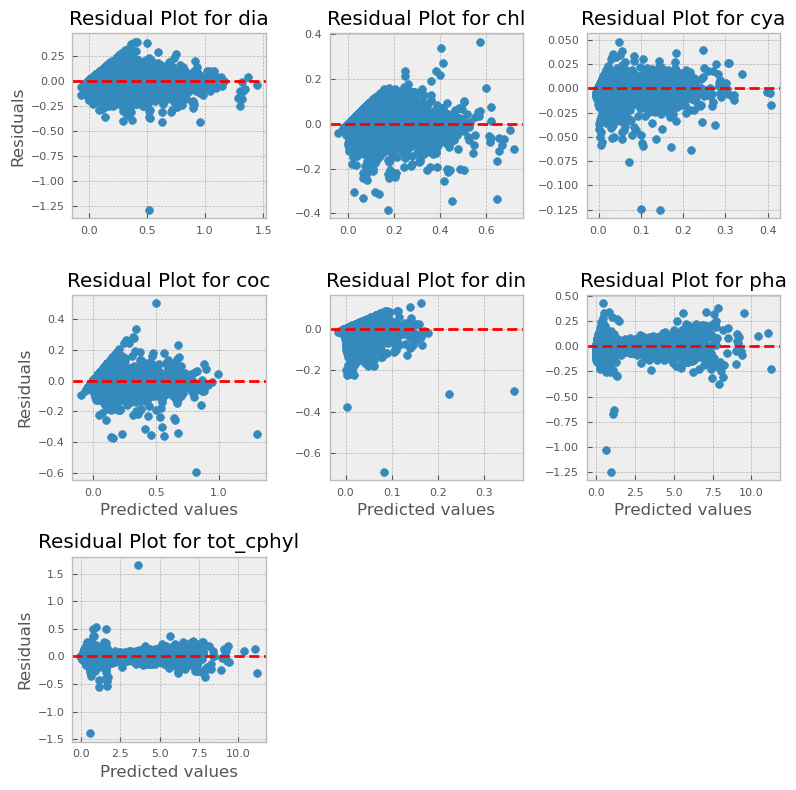

In [48]:
f, axs = pp.subplots(nrows=3, ncols=3, figsize=(8, 8))
for ax, col in zip(axs.ravel(), dY_test.columns):
    try:
        plot_residuals(dY_test[col].values, dY_pred[col].values, ax, col)
    except:
        logger.error(f"problem with {col}")
axs.ravel()[-2].set_visible(False)
axs.ravel()[-1].set_visible(False)
f.tight_layout()

In [49]:
f.savefig(figures_path/'residuals.png', bbox_inches='tight', dpi=300)

In [50]:
eval_scores = model_eval(dY_test, dY_pred)

2025-03-20 13:15:26.313 | INFO     | scripts.evaluate:model_eval:21 - 
Metrics for dia:
2025-03-20 13:15:26.313 | INFO     | scripts.evaluate:model_eval:22 -   MSE: 0.0003
2025-03-20 13:15:26.314 | INFO     | scripts.evaluate:model_eval:23 -   RMSE: 0.0184
2025-03-20 13:15:26.314 | INFO     | scripts.evaluate:model_eval:24 -   MAE: 0.0088
2025-03-20 13:15:26.314 | INFO     | scripts.evaluate:model_eval:25 -   R-squared: 0.9790
2025-03-20 13:15:26.314 | INFO     | scripts.evaluate:model_eval:26 -   MAE/StDev_true 0.069
2025-03-20 13:15:26.319 | INFO     | scripts.evaluate:model_eval:21 - 
Metrics for chl:
2025-03-20 13:15:26.320 | INFO     | scripts.evaluate:model_eval:22 -   MSE: 0.0001
2025-03-20 13:15:26.320 | INFO     | scripts.evaluate:model_eval:23 -   RMSE: 0.0100
2025-03-20 13:15:26.321 | INFO     | scripts.evaluate:model_eval:24 -   MAE: 0.0042
2025-03-20 13:15:26.321 | INFO     | scripts.evaluate:model_eval:25 -   R-squared: 0.9582
2025-03-20 13:15:26.322 | INFO     | scripts.

In [51]:
df_scores = pd.DataFrame(eval_scores)
df_scores.to_parquet('./tabled_results/df_post_hpo_eval_scores_test_set_.pqt')

In [52]:
df_scores= pd.read_parquet('./tabled_results/df_post_hpo_eval_scores_test_set_.pqt')

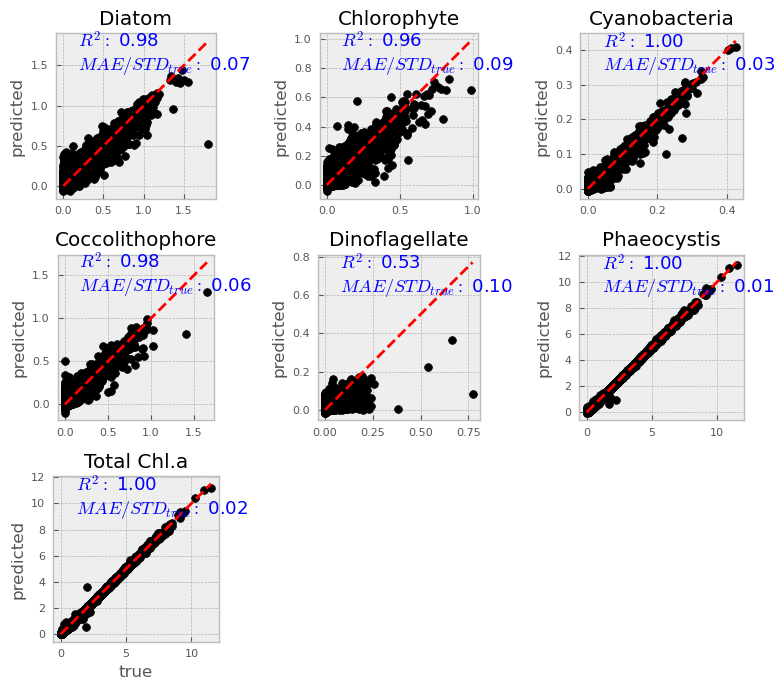

In [57]:
f_fit, axs = pp.subplots(nrows=3, ncols=3, figsize=(8, 7))
columns = ['Diatom', 'Chlorophyte', 'Cyanobacteria', 'Coccolithophore', 'Dinoflagellate', 'Phaeocystis', 'Total Chl.a']
for col, ax, lbl in zip(dY_test.columns, axs.ravel(), columns):
    r2 = eval_scores[col]['r2']
    mae2truestd = eval_scores[col]['mae_2_true_std_ratio']
    string = r'$R^2:$ ' + f'{r2:.2f}\n' + r'$MAE/STD_{true}:$ ' + f'{mae2truestd:.2f}'
    plot_regression(dY_test[col], dY_pred[col], col, ax=ax, leg=string)
    ax.set(title=lbl, ylabel='predicted')
for ax in axs.ravel()[-2:]:
    ax.set_visible(False)
f_fit.tight_layout()
f_fit.savefig(figures_path / 'goodness-of-fit_rrs_env.png', bbox_inches='tight', dpi=300)

In [19]:
df_scores

,dia,chl,cya,coc,din,pha,tot_cphyl
mse,0.000172,0.000043,0.000001,0.000036,0.000006,0.000045,0.000093
rmse,0.013119,0.006578,0.001184,0.006036,0.002444,0.006686,0.009630
mae,0.006838,0.003099,0.000638,0.003223,0.000388,0.002208,0.006071
r2,0.989343,0.981951,0.997896,0.993470,0.856912,0.999741,0.999422
mae_2_true_std_ratio,0.053806,0.063304,0.024743,0.043145,0.060009,0.005314,0.015154


In [59]:
formatted_df = df_scores.map(lambda x: "{:.2e}".format(x))
formatted_df.rename(
    columns=dict(
        dia='diatom', chl='chloroph', cya='cyanobac', coc='coccolit', din='dinoflag', pha='phaeo', tot_cphyl='tot chl a'
        ), 
    index=dict(
        mse='Mean Squared Error', rmse='Root MSE', mae='Mean Abs. Error', r2='R squared', mae_2_true_std_ratio = 'MAE : Std. Dev of True'
        ),
    inplace=True
    )

formatted_df

,diatom,chloroph,cyanobac,coccolit,dinoflag,phaeo,tot chl a
Mean Squared Error,3.40e-04,1.00e-04,2.89e-06,8.59e-05,1.96e-05,1.10e-04,1.93e-04
Root MSE,1.84e-02,1.00e-02,1.70e-03,9.27e-03,4.43e-03,1.05e-02,1.39e-02
Mean Abs. Error,8.78e-03,4.20e-03,7.80e-04,4.20e-03,6.37e-04,3.13e-03,7.28e-03
R squared,9.79e-01,9.58e-01,9.96e-01,9.85e-01,5.30e-01,9.99e-01,9.99e-01
MAE : Std. Dev of True,6.91e-02,8.58e-02,3.02e-02,5.63e-02,9.86e-02,7.54e-03,1.82e-02


In [60]:
formatted_df.to_markdown()

'|                        |   diatom |   chloroph |   cyanobac |   coccolit |   dinoflag |   phaeo |   tot chl a |\n|:-----------------------|---------:|-----------:|-----------:|-----------:|-----------:|--------:|------------:|\n| Mean Squared Error     |  0.00034 |     0.0001 |   2.89e-06 |   8.59e-05 |   1.96e-05 | 0.00011 |    0.000193 |\n| Root MSE               |  0.0184  |     0.01   |   0.0017   |   0.00927  |   0.00443  | 0.0105  |    0.0139   |\n| Mean Abs. Error        |  0.00878 |     0.0042 |   0.00078  |   0.0042   |   0.000637 | 0.00313 |    0.00728  |\n| R squared              |  0.979   |     0.958  |   0.996    |   0.985    |   0.53     | 0.999   |    0.999    |\n| MAE : Std. Dev of True |  0.0691  |     0.0858 |   0.0302   |   0.0563   |   0.0986   | 0.00754 |    0.0182   |'

### Methods

#### Data Preparation and Feature Selection
We utilized a simulated dataset representing the world ocean over 31 days, corresponding to December 2021. The simulation generated hyperspectral remote sensing reflectance (Rrs) data, emulating a sensor configuration akin to that of the PACE instrument. Due to the high dimensionality of the original spectral data, we conducted an initial exploratory analysis and observed strong correlations among many of the channels. To reduce redundancy while preserving the essential spectral information, we retained 51 channels by selecting one channel every 10. We opted against applying principal component analysis (PCA) because preliminary investigations indicated that PCA tended to overemphasize the signal from extensive blue water areas—a phenomenon known as “blue water tyranny”—which could mask coastal processes of interest. In addition to these 51 spectral channels, we included auxiliary environmental variables such as temperature and latitude.

The entire dataset was divided into training and test sets using an 80/20 split. The training set was exclusively used for model development and hyperparameter optimization, while the test set was reserved for the final validation of model performance.

#### Modeling and Hyperparameter Optimization
We employed an XGBoost Regressor model wrapped within a multi-output regression structure to simultaneously predict multiple phytoplankton functional groups as well as total chlorophyll-a concentration. XGBoost is a high-performance, scalable implementation of gradient boosting that has become a popular choice for a wide range of regression and classification tasks (Chen *et al.* 2016). It builds an ensemble of decision trees sequentially, where each new tree attempts to correct the errors made by the previous trees. By optimizing a regularized objective function, XGBoost effectively controls overfitting while enhancing prediction accuracy. Its efficient handling of sparse data, support for parallel computation, and flexible regularization mechanisms make it particularly well-suited for complex modeling tasks, such as predicting multiple phytoplankton functional groups and total chlorophyll-a concentration from hyperspectral and ancillary oceanographic data.


Given the complexity of the problem and the high dimensionality of the input features, it was critical to optimize the hyperparameters to achieve robust performance and prevent overfitting. To this end, we conducted hyperparameter optimization using a Bayesian optimization approach implemented with Optuna. The objective function minimized the root mean squared error (RMSE) computed via three-fold cross-validation on the training set. The hyperparameters under investigation included the learning rate, maximum tree depth, number of estimators, subsample ratio, column subsample ratio, and gamma (the minimum loss reduction required to make a further partition on a leaf node). The Bayesian optimization procedure allowed us to efficiently explore the hyperparameter space by leveraging past trial information to prune unpromising candidates early, thereby reducing overall computational cost.

Once the optimal hyperparameter combination was identified, we retrained the final XGBoost model on the full training set using these optimized settings. Finally, we evaluated the performance of the retrained model on the held-out test set to assess its generalizability.

Code Availability - All code used in this study is publicly available on GitHub (URL to GitHub repository).



### Results

#### Hyperparameter Optimization (HPO)

We performed hyperparameter optimization using a Bayesian optimization framework implemented with Optuna. The metric used for optimization was the average RMSE (in units of $mgL^{-1} Chl_a$ ) computed over the cross-validation folds and across all target compartments. The “full HPO run” best parameters indicate a relatively aggressive model, characterized by deep trees with many estimators, a moderate learning rate, and little regularization via gamma.

The best trial finished with an RMSE of $0.116mgL^{-1} Chl_a$. Below is the list of hyperparameters researched, the optimal values found, and an interpretation of these values:

*  Learning Rate (learning_rate): $0.083$ - This moderate learning rate suggests the model takes reasonably sized steps when updating that are neither too aggressive (which might lead to overshooting the optimum) nor too conservative (which could slow down convergence). 

* Max Depth (max_depth): $10$ - A depth of 10 allows the trees to capture complex interactions. This may indicate that the data has non-linear relationships that benefit from deeper trees. Such a depth can be associated with overfitting. The cross-validation process during HPO should minimize this however.

* Number of Estimators (n_estimators): $466$ -Building around 466 trees indicates the ensemble haa to tackle inherent complexity in the data that was not apparetn during the Exploratory Data Analysis phase. A larger number of trees generally improves performance—up to a point before overfitting becomse a risk.  This number in conjunction with the cross validation process suggest this number strikes a balance between performance and overfitting.

* Subsampling (subsample): $0.658$ - This indicates each of the 466 trees is using roughly 66% of the data. This introduces randomness that helps prevent overfitting as not all samples in any cross-validation fold are used to build every tree.

* Features used per tree (colsample_bytree): $0.894$ - Using about 89% of the features per tree indicates that most features are informative, and the model is allowed to consider almost the full feature set at each split. - See features used in the Methods section.
    
* Gamma (gamma): $8.63e-06$ - An extremely low gamma value means that almost no minimum loss reduction is required to make a split. This implies that the algorithm will split more readily, potentially capturing fine details. Awareness of this hyperparameter values is important as low gamma  can risk overfitting.


#### Optimized Model Validation

The next step was to load the best set of hyperparameter (listed above) into the model and retrain the model on the entire training set. The optimized and trained model was then validated using the test set, which prior to the HPO process and until this step had been set aside . This validation step ensured that the model performed satisfactorily on unseen data and was ready for prediction on new data. The following performance metrics were recorded during validation:

- **Mean Squared Error (MSE):**  
  MSE is the average of the squared differences between the predicted and true values. Squaring the errors emphasizes larger deviations, making MSE sensitive to outliers. In our context, MSE is expressed in units of (mg L$^{-1}$ Chl$_a$)$^2$. Lower MSE values indicate better model performance.

- **Root Mean Squared Error (RMSE):**  
  RMSE is the square root of the MSE, bringing the error metric back to the original units (mg L$^{-1}$ Chl$_a$). It provides a direct measure of the average prediction error magnitude. Lower RMSE values suggest that the model’s predictions are closer to the true values.

- **Mean Absolute Error (MAE):**  
  MAE calculates the average absolute difference between predicted and true values. Unlike MSE, it does not square the errors, so it is less sensitive to large outliers. MAE is also expressed in the same units as the target variable (mg L$^{-1}$ Chl$_a$). A lower MAE indicates better predictive accuracy.

- **Coefficient of Determination (R-squared):**  
  R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1, where a value closer to 1 indicates that the model explains a high proportion of the variance in the data. In our results, high R-squared values generally indicate strong model performance, although lower values (e.g., for dinoflagellates) suggest room for improvement.

- **MAE/StDev$_{true}$:**  
  This ratio compares the mean absolute error to the standard deviation of the true values. It provides a relative measure of error by indicating how the average error compares to the inherent variability in the data. A lower ratio implies that the model’s prediction error is small relative to the natural variability of the observations.

  After retraining the final model using the best hyperparameters identified during hyperparameter optimization, we evaluated its performance on the held-out test set. The following metrics were computed for each target output (with units in $mg L^{-1} Chl_a in the case of RMSE and MAE):






### Interpretation of Validation Metrics

The table above summarizes the performance of our optimized model for each target output, as well as an overall average across the phytoplankton functional groups (PFG mean) and total chlorophyll-a. We discuss each metric and what it reveals about model performance:

- **MSE (Mean Squared Error):**  
  The MSE values are very low for all targets (on the order of $10^{-4}$ or lower), which indicates that the average squared error is minimal. Notably, cyanobacteria achieved an exceptionally low MSE ($2.92 \times 10^{-6}$), whereas the values for the other outputs are slightly higher but still low. This suggests that, overall, the model errors are small when averaged over the squared differences.

- **RMSE (Root Mean Squared Error):**  
  RMSE values, expressed in mg L$^{-1}$ Chl$_a$, are similarly low. For example, diatoms have an RMSE of 0.0184, while chlorophyll-a has an RMSE of 0.00992. The RMSE for total chlorophyll-a (0.0139) and the PFG mean (0.00913) are comparable, reinforcing that the model performs well overall. However, dinoflagellates show a lower RMSE (0.00464), which may be due to their lower absolute concentrations and smaller error magnitudes, even though other metrics (like $R^2$) suggest less reliable performance for this group.

- **MAE (Mean Absolute Error):**  
  The MAE values provide a direct measure of average error magnitude. Again, these are low across targets—for instance, MAE for cyanobacteria is $7.77 \times 10^{-4}$ and for phaeocystis is 0.00315. The relatively low MAE for the aggregated PFG mean (0.00362) indicates that, on average, our predictions deviate very little from the true values.

- **R-squared ($R^2$):**  
  $R^2$ values are very high (close to 1) for most outputs, with diatoms, chlorophyll-a, cyanobacteria, coccolithophores, phaeocystis, and total chlorophyll-a all showing $R^2$ values above 0.98. This suggests that the model explains almost all the variance in the observed data for these targets. However, dinoflagellates have a notably lower $R^2$ (0.488), indicating that the model struggles to capture the variability for this group, which may warrant further investigation or a dedicated modeling strategy.

- **MAPE (Mean Absolute Percentage Error):**  
  MAPE values are extremely large for most targets (on the order of $10^{10}$ or $10^{11}$), except for total chlorophyll-a, which shows a much lower MAPE (approximately $3.23 \times 10^{4}$). This discrepancy is likely due to the very small true values for some of the targets, where even a small absolute error translates into an enormous percentage error. As such, MAPE may not be the most informative metric in this context.

- **MAE/StDev$_{true}$ (Ratio of MAE to the Standard Deviation of the True Values):**  
  This ratio provides a relative measure of error compared to the natural variability in the data. Lower ratios are desirable. For phaeocystis, the ratio is very low (0.00735), indicating that the error is minimal relative to the true variability. Conversely, dinoflagellates exhibit a higher ratio (0.0986), reinforcing that prediction accuracy for this group is comparatively worse.


In summary, the model exhibits high accuracy and precision for most targets, with low error metrics and high explanatory power. However, the relatively poor $R^2$ and higher error ratios for dinoflagellates suggest that further refinement may be needed for this particular functional group. Overall, these results validate the efficacy of our optimized model in predicting both individual phytoplankton functional groups and total chlorophyll-a.




### Discussion

The objective of this study was to develop and validate a machine learning model capable of retrieving phytoplankton functional group (PFG) concentrations from hyperspectral remote sensing reflectance (Rrs) data, simulating the capabilities of the upcoming Plankton, Aerosol, Cloud, and ocean Ecosystem (PACE) mission. Using an XGBoost-based multi-output regression approach, we leveraged a simulated dataset representing the global ocean over December 2021 to train and optimize the model. Our workflow included systematic feature selection, hyperparameter optimization via Bayesian optimization, and rigorous cross-validation to ensure robust performance across diverse phytoplankton groups.

#### Model Performance and Key Findings

The model demonstrated strong predictive performance across most PFGs, with low RMSE and MAE values and high $R^2$ values exceeding 0.95 for diatoms, chlorophyll-a, cyanobacteria, coccolithophores, and phaeocystis. The overall average $R^2$ across all groups was 0.90, indicating that the model successfully captured a significant proportion of the variance in phytoplankton group concentrations. Total chlorophyll-a retrieval was particularly accurate ($R^2 = 0.999$), reflecting the well-characterized relationship between ocean color and bulk chlorophyll-a concentration.

However, dinoflagellates exhibited notably lower predictive accuracy ($R^2 = 0.49$), suggesting potential limitations in distinguishing this group based solely on the available optical features. Dinoflagellates are known to exhibit highly variable pigment compositions and optical signatures, particularly in mixed assemblages where their spectral signal may be masked by co-occurring groups. This highlights the potential need for additional constraints, such as ecological priors or regional-specific tuning, to improve retrieval accuracy for this functional group.

Another notable observation was the large mean absolute percentage error (MAPE) for most groups. This is likely a result of very low absolute concentrations in some regions, where even small absolute errors result in large percentage deviations. While MAPE is commonly used for regression evaluation, it may be less informative in this context due to the order-of-magnitude differences in PFG concentrations across different oceanic regimes.

#### Implications for PACE and Future Applications

The results demonstrate that machine learning methods, particularly gradient boosting, provide an effective approach for retrieving phytoplankton functional groups from hyperspectral satellite data. The high accuracy achieved for most groups suggests that these techniques could complement traditional spectral unmixing approaches and contribute to improved global monitoring of phytoplankton biodiversity. Given PACE’s unprecedented spectral resolution, further refinements—such as incorporating additional environmental predictors (e.g., nutrient availability, and mixed-layer depth) or employing hybrid modeling approaches that integrate optical and ecological constraints—could enhance model performance.

#### Limitations and Future Work

Several areas warrant further investigation to refine and extend this modeling approach. First, while the model performed well across most groups, its performance for dinoflagellates was lower (e.g. $R^2=0.49$). One potential reason for encountering this particularly in real data is the complex optical properties and ecological traits of this phytoplankton group. Unlike diatoms or cyanobacteria, many dinoflagellates exhibit mixotrophy, vertical migration, and non-standard pigment compositions, such as peridinin, which can complicate their spectral signal and introduce variability not well captured by standard ocean color-based models (Stoecker et al., 2017). Additionally, dinoflagellates are often more prevalent in coastal and stratified waters (Tester et al., 2014), environments that are optically complex and subject to influence from dissolved organic matter, sediments, and other non-algal particles, which may confound the retrieval process. These factors likely contribute to increased uncertainty in the model’s ability to accurately predict dinoflagellate concentrations, suggesting that additional spectral or environmental features, such as fluorescence or stratification indices, may be necessary to improve performance.

Second, the current model was trained on a simulated dataset; its performance on actual satellite observations should be carefully evaluated once PACE data become available. Third, while we applied Bayesian optimization for hyperparameter tuning, further exploration of deep learning approaches, particularly convolutional or transformer-based architectures designed for spectral data, may offer additional improvements.

### Conclusion

This study demonstrates the potential of machine learning for phytoplankton functional group retrieval from PACE-like hyperspectral observations. By leveraging feature selection, hyperparameter optimization, and rigorous validation, we developed a model that achieves high accuracy across most phytoplankton groups. These results provide a foundation for future efforts to operationalize hyperspectral-based phytoplankton monitoring and further enhance our ability to characterize oceanic ecosystem dynamics from space.

To ensure full reproducibility and facilitating future developments in hyperspectral ocean color remote sensing, all code used in this study are available on [GitHub](https://github.com/placeholder), datasets are available on the Open Science Foundation website, [here](https://OSF.repo.placeholder). 



Litterature Cited:

Chen, T. and Guestrin, C. *(2016)* XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD '16), pages 785–794. doi:10.1145/2939672.2939785

Tester, P.A., Kibler, S.R., Holland, W.C., Usup, G., Vandersea, M.W., Leaw, C.P., & Litaker, R.W. *(2014)* Sampling harmful benthic dinoflagellates: Comparison of artificial and natural substrate methods. Harmful Algae, 39, 8-25. https://doi.org/10.1016/j.hal.2014.06.009​


Stoecker, D.K., Hansen, P.J., Caron, D.A., & Mitra, A. *(2017)* Mixotrophy in the Marine Plankton. Annual Review of Marine Science, 9, 311-335. https://doi.org/10.1146/annurev-marine-010816-060617